<a href="https://colab.research.google.com/github/Aniket-687/Credit_Card_Financial_Dashboard/blob/main/Spatial_transcriptomics_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install core spatial transcriptomics packages

In [ ]:
!pip3 install --quiet --upgrade scanpy squidpy anndata igraph leidenalg
# Optional: Silence Dask warning
import dask
dask.config.set({'dataframe.query-planning': None})

"\nimport dask\ndask.config.set({'dataframe.query-planning': None})\n"

## Importing the libraries

In [ ]:
import scanpy as sc
import squidpy as sq
import os
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text

### Loading the dataset

In [ ]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()

# Show basic structure
adata

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### Adding annotation for mitochondrial genes

In [ ]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculating QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

### Filtering out spots with less than 200 genes

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)

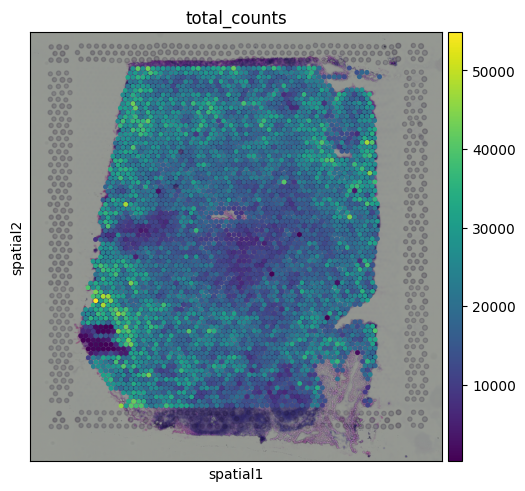

In [ ]:
# Visualizing total counts per spot
sq.pl.spatial_scatter(
    adata,
    color="total_counts",
    size=1.5
)

## Log normalising the expression data

In [ ]:
# Normalizing to 10,000 total counts per spot
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transforming the data
sc.pp.log1p(adata)

In [ ]:
# Selecting highly variable genes
sc.pp.highly_variable_genes(adata)

### Dimensionality reduction and visualization

In [ ]:
# Running PCA
sc.pp.pca(adata, n_comps=50)

# Calculate neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.8)

# Computing UMAP
sc.tl.umap(adata)

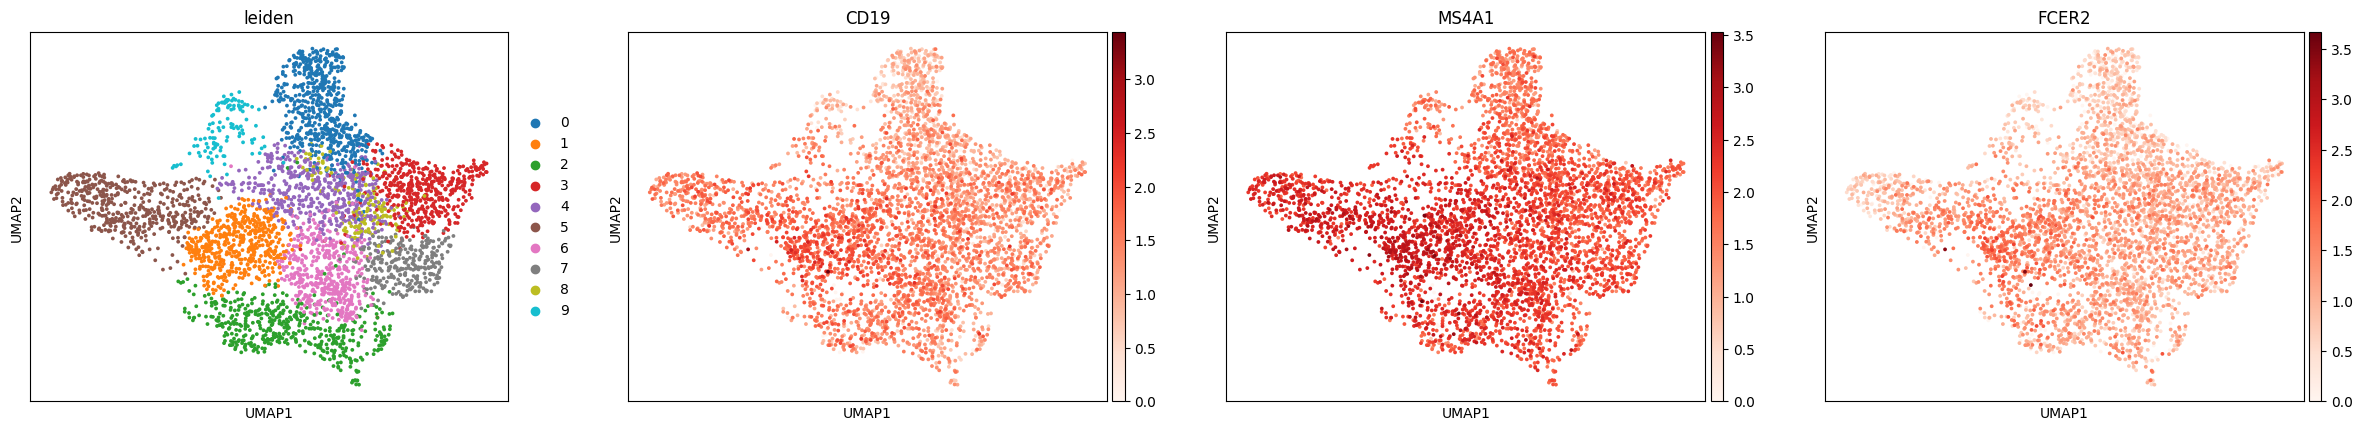

In [ ]:
# Visualizing marker genes
sc.pl.umap(adata, color=['leiden', 'CD19', 'MS4A1', 'FCER2'], cmap = 'Reds')

## Histology imaging

In [ ]:
img = adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires']
print(f"Shape: {img.shape}, Type: {type(img)}, Dtype: {img.dtype}")

# First top left pixels
img[:3, :3, :]

Shape: (2000, 1921, 3), Type: <class 'numpy.ndarray'>, Dtype: float32


array([[[0.5882353 , 0.6       , 0.5764706 ],
        [0.58431375, 0.6       , 0.5686275 ],
        [0.5882353 , 0.6       , 0.5686275 ]],

       [[0.5882353 , 0.6       , 0.57254905],
        [0.5882353 , 0.6       , 0.5764706 ],
        [0.58431375, 0.6       , 0.5764706 ]],

       [[0.58431375, 0.6       , 0.5803922 ],
        [0.58431375, 0.6       , 0.5764706 ],
        [0.58431375, 0.59607846, 0.57254905]]], dtype=float32)

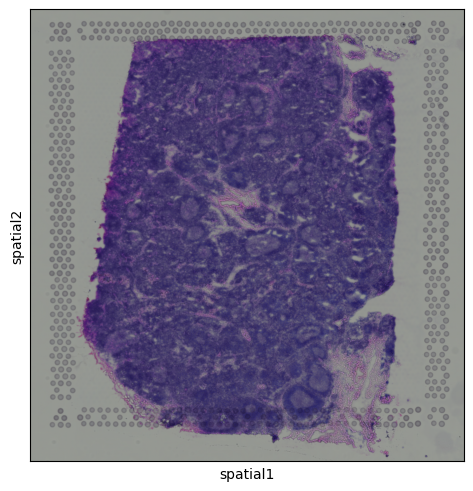

In [ ]:
sq.pl.spatial_scatter(adata)

## Image feature calculation

In [ ]:
# Define image container
img = sq.im.ImageContainer.from_adata(adata)

In [ ]:
sq.im.calculate_image_features(
    adata,
    img,
    features="summary",
    key_added="image_features"
)

  0%|          | 0/4032 [00:00<?, ?/s]

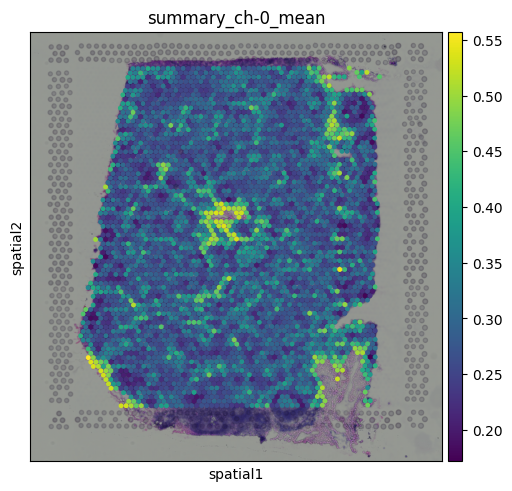

In [ ]:
# Transfering to obs for plotting
adata.obs["summary_ch-0_mean"] = adata.obsm["image_features"]["summary_ch-0_mean"]
sq.pl.spatial_scatter(
    adata,
    color="summary_ch-0_mean",
    size=1.5
)

## Clustering the image features

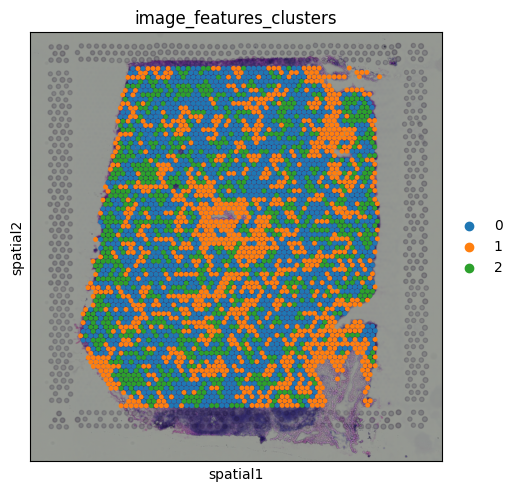

In [ ]:
sc.pp.neighbors(adata, use_rep="image_features")
sc.tl.leiden(adata, key_added="image_features_clusters", resolution = 0.1)

#adata.uns.pop('image_features_clusters_colors')
sq.pl.spatial_scatter(
    adata,
    color="image_features_clusters",
    size=1.5
)


## Spatial Coordinates

In [ ]:
# Extracting spatial coordinates
coords = adata.obsm["spatial"]
print(f"Shape: {coords.shape}, Type: {type(coords)}, Dtype: {coords.dtype}")

# First few coordinates
coords[:3, :]

Shape: (4032, 2), Type: <class 'numpy.ndarray'>, Dtype: int64


array([[8346, 6982],
       [4270, 1363],
       [2635, 8074]])

## Building Spatial neighbourhood graph

In [ ]:
sq.gr.spatial_neighbors(adata, coord_type="grid")

In [ ]:
adata.obsp["spatial_connectivities"].shape

(4032, 4032)

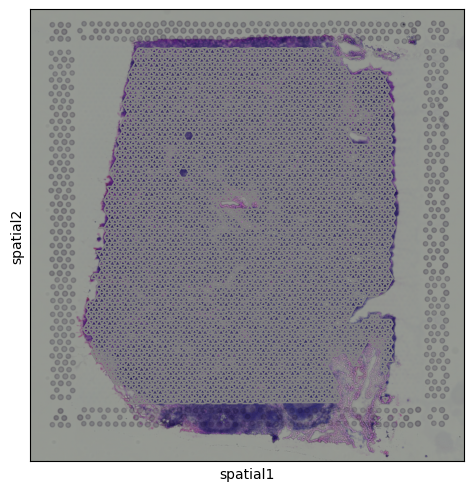

In [ ]:
sq.pl.spatial_scatter(adata, connectivity_key="spatial_connectivities")

## Gene expression features observed in tissue

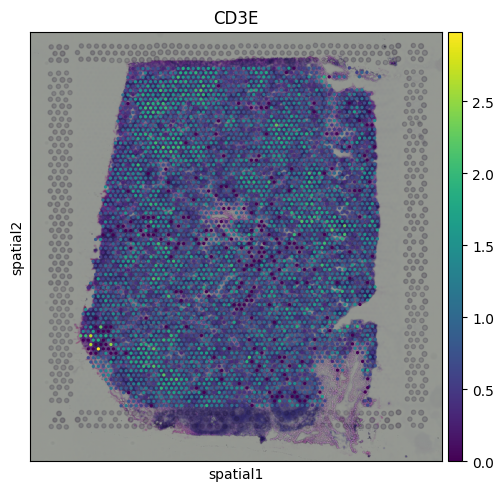

In [ ]:
sq.pl.spatial_scatter(adata, color = 'CD3E')

## Spatial mapping of Gene expression clusters

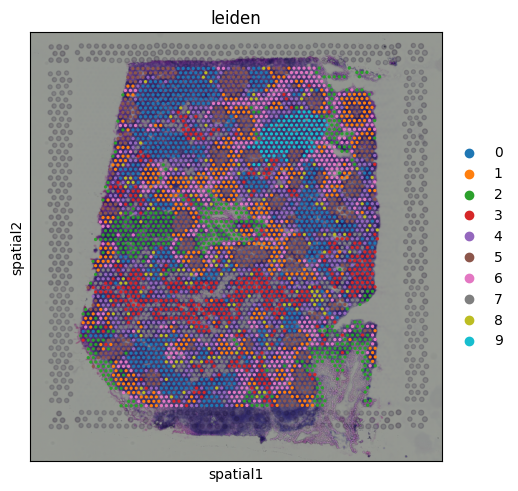

In [ ]:
sq.pl.spatial_scatter(adata, color = 'leiden')

## Finding the marker gene in a localised cluster

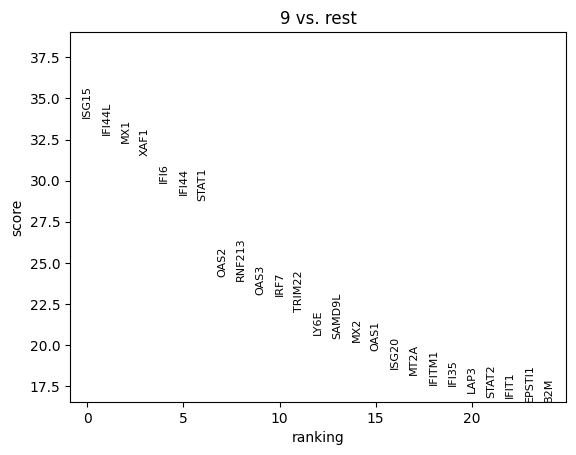

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=25, groups = ['9'])

## Visualising gene expression of a localised marker gene

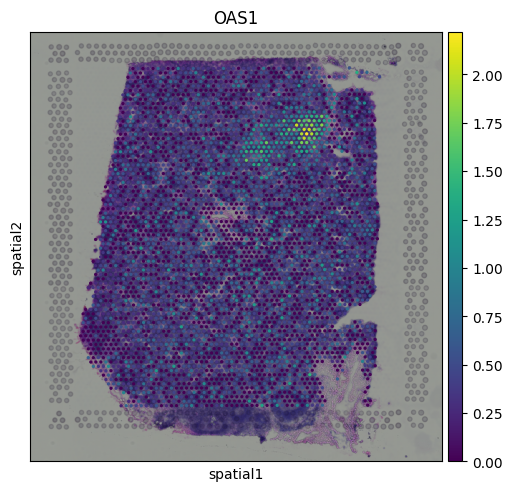

In [ ]:
sq.pl.spatial_scatter(adata, color = ['OAS1'])

## Finding Spatially variable genes

In [ ]:
sq.gr.spatial_autocorr(adata, mode="moran")

In [ ]:
# Top spatially structured genes
adata.uns["moranI"]["I"].sort_values(ascending = False)[0:15]

FDCSP      0.701889
IGHG2      0.656459
MT-CO1     0.609527
CR2        0.598975
MT-CO2     0.586977
CXCL13     0.546026
MT-ND4     0.538226
CLU        0.526424
MT-ND3     0.518973
MT-ATP6    0.515217
MT-CYB     0.498500
CCL19      0.497364
JCHAIN     0.494780
IGLC3      0.488655
MT-ND1     0.474826
Name: I, dtype: float64

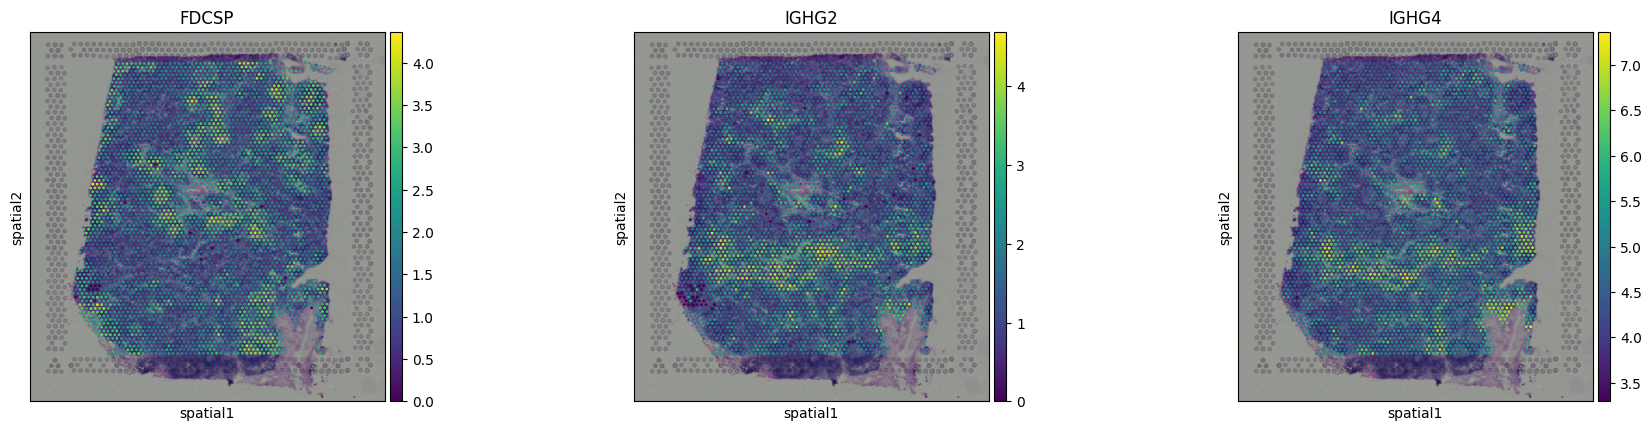

In [ ]:
sq.pl.spatial_scatter(adata, color = ['FDCSP','IGHG2','IGHG4'])

## Segmenting tissue into spatial domains

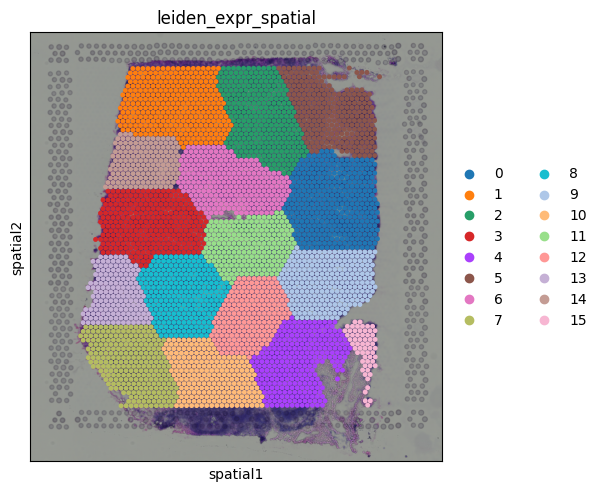

In [ ]:
# Extract PCA and spatial coordinates
X_pca = adata.obsm["X_pca"][:, :10]  # use first 10 PCs
X_spatial = adata.obsm["spatial"]

# Concatenate PCA + spatial into a new matrix
X_combined = np.concatenate([X_pca, X_spatial], axis=1)
adata.obsm["X_expr_space"] = X_combined

# Build neighbor graph and cluster using the combined features
sc.pp.neighbors(adata, use_rep="X_expr_space")
sc.tl.leiden(adata, key_added="leiden_expr_spatial", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial", size=1.5)

## Scaling the data and then segmenting

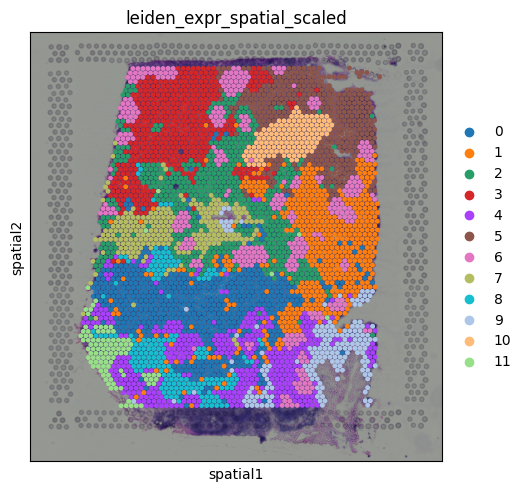

In [ ]:
# Scale values
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

scaler_spatial = StandardScaler()
X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

# Combine into one matrix
X_combined = np.concatenate([X_pca_scaled, X_spatial_scaled], axis=1)
adata.obsm["X_expr_spatial_scaled"] = X_combined

# Neighbors + clustering
sc.pp.neighbors(adata, use_rep="X_expr_spatial_scaled")
sc.tl.leiden(adata, key_added="leiden_expr_spatial_scaled", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial_scaled", size=1.5)